# Model validation

In [2]:
!hostname
!python -c "import jax; print(jax.default_backend(), jax.devices())"
# !nvidia-smi
# numpyro.set_platform("gpu")

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.33' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

import numpyro
from numpyro.handlers import seed, condition, trace

%matplotlib inline
%load_ext autoreload 
%autoreload 2

feynmangpu04.cluster.local


gpu [cuda(id=0)]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Render model

2023-12-19 09:20:06.056223: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


model_kwargs={'mesh_size': array([256, 256, 256]), 'box_size': array([1000, 1000, 1000]), 'scale_factor_lpt': 0.5, 'scale_factor_obs': 0.5, 'galaxy_density': 0.001, 'trace_reparam': True, 'trace_deterministic': True}
cell_lengths=[3.90625, 3.90625, 3.90625] Mpc/h
k_nyquist=0.80425 h/Mpc, delta_k=0.00628 h/Mpc
mean_galaxy_cell_intensity=0.060 galaxy/cell


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **

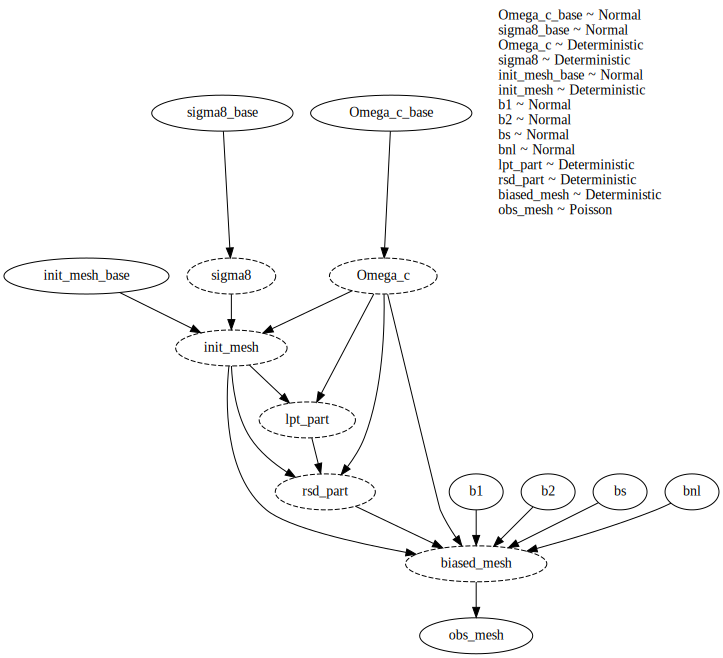

In [3]:
from montecosmo.models import forward_model, model_kwargs
model_kwargs['trace_deterministic'] = True
model_kwargs['scale_factor_lpt'] = 0.5
model_kwargs['scale_factor_obs'] = 0.5
model_kwargs['mesh_size'] = np.array([256,256,256])
model_kwargs['box_size'] = np.array([1000,1000,1000])
print(f"{model_kwargs=}")

# Print infos
cell_lengths = list( model_kwargs['box_size'] / model_kwargs['mesh_size'] )
print(f"{cell_lengths=} Mpc/h")

k_nyquist = 2 * jnp.pi * jnp.min(model_kwargs['mesh_size'] / model_kwargs['box_size']) / 2
delta_k = 2 * jnp.pi * jnp.max(1 / model_kwargs['box_size']) 
# (2\pi factor because of Fourier transform definition)
print(f"{k_nyquist=:.5f} h/Mpc, {delta_k=:.5f} h/Mpc")

mean_galaxy_cell_intensity = model_kwargs['galaxy_density'] * model_kwargs['box_size'].prod() / model_kwargs['mesh_size'].prod()
print(f"{mean_galaxy_cell_intensity=:.3f} galaxy/cell")

# Render model
numpyro.render_model(model=forward_model, model_kwargs=model_kwargs, render_distributions=True, render_params=True)

## Simulate fiducial

In [4]:
# Cosmological parameters
cosmo_var_names = ['Omega_c', 'sigma8']
cosmo_var_labels = [r'\Omega_c', r'\sigma_8']
# TODO: dict name:(mean, var) or (min,max) for cosmo_prior?

# Condition model on some cosmology and sample
cond_params = {var_name+"_base": 0. for var_name in cosmo_var_names}
fiducial_model = condition(forward_model, cond_params) # NOTE: Only condition on random sites, not deterministic ones
fiducial_trace = trace(seed(fiducial_model, rng_seed=0)).get_trace(**model_kwargs)

# Check cosmology
fiducial_cosmo_params = {var_name: fiducial_trace[var_name]['value'] for var_name in cosmo_var_names}
from jax_cosmo import Planck15
fiducial_cosmology = Planck15(**fiducial_cosmo_params)
print(f"Fiducial {fiducial_cosmology}")

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Fiducial Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.25 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.831


## Power spectra

In [34]:
from jaxpm.painting import cic_paint, cic_read, compensate_cic
from montecosmo.bricks import linear_pk_interp
from montecosmo.metrics import power_spectrum

# Get meshes from model trace
init_mesh = fiducial_trace['init_mesh']['value']
biased_mesh = fiducial_trace['biased_mesh']['value']
obs_mesh = fiducial_trace['obs_mesh']['value']
# Get other meshes from model trace particles, compensate for CIC painting convolution
zeros_mesh = jnp.zeros(model_kwargs['mesh_size'])
lpt_mesh = cic_paint(zeros_mesh, fiducial_trace['lpt_part']['value'])
rsd_mesh = cic_paint(zeros_mesh, fiducial_trace['rsd_part']['value'])

# Compute power spectra
pk_lin_init = linear_pk_interp(fiducial_cosmology)
pk_lin_lpt = linear_pk_interp(fiducial_cosmology, a=model_kwargs['scale_factor_lpt'])
pk_lin_obs = linear_pk_interp(fiducial_cosmology, a=model_kwargs['scale_factor_obs'])

multipoles = [0, 2, 4]
dk = 0.01
pk_init = power_spectrum(init_mesh, kmin=0.001, dk=0.01, box_size=model_kwargs['box_size'], multipoles=multipoles)
pk_lpt = power_spectrum(compensate_cic(lpt_mesh), kmin=0.001, dk=dk, box_size=model_kwargs['box_size'], multipoles=multipoles)
pk_rsd = power_spectrum(compensate_cic(rsd_mesh), kmin=0.001, dk=dk, box_size=model_kwargs['box_size'], multipoles=multipoles)
pk_biased = power_spectrum(compensate_cic(biased_mesh), kmin=0.001, dk=dk, box_size=model_kwargs['box_size'], multipoles=multipoles)

In [35]:
from montecosmo.metrics import kaiser_formula
from montecosmo.bricks import apply_kaiser_bias

fiducial_eulerian_bias = condition(apply_kaiser_bias, {'b': 1+fiducial_trace['b1']['value']})
kaiser_mesh = fiducial_eulerian_bias(fiducial_cosmology, model_kwargs['scale_factor_obs'], init_mesh)
pk_kaiser_bias = power_spectrum(kaiser_mesh, kmin=0.001, dk=dk, box_size=model_kwargs['box_size'], multipoles=multipoles)

pk_kaiser_lin = pk_init[0], kaiser_formula(fiducial_cosmology, model_kwargs['scale_factor_obs'], pk_lin_init(pk_init[0]), 1+fiducial_trace['b1']['value'], multipoles)
pk_kaiser_init = pk_init[0], kaiser_formula(fiducial_cosmology, model_kwargs['scale_factor_obs'], pk_init[1][0], 1+fiducial_trace['b1']['value'], multipoles)

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


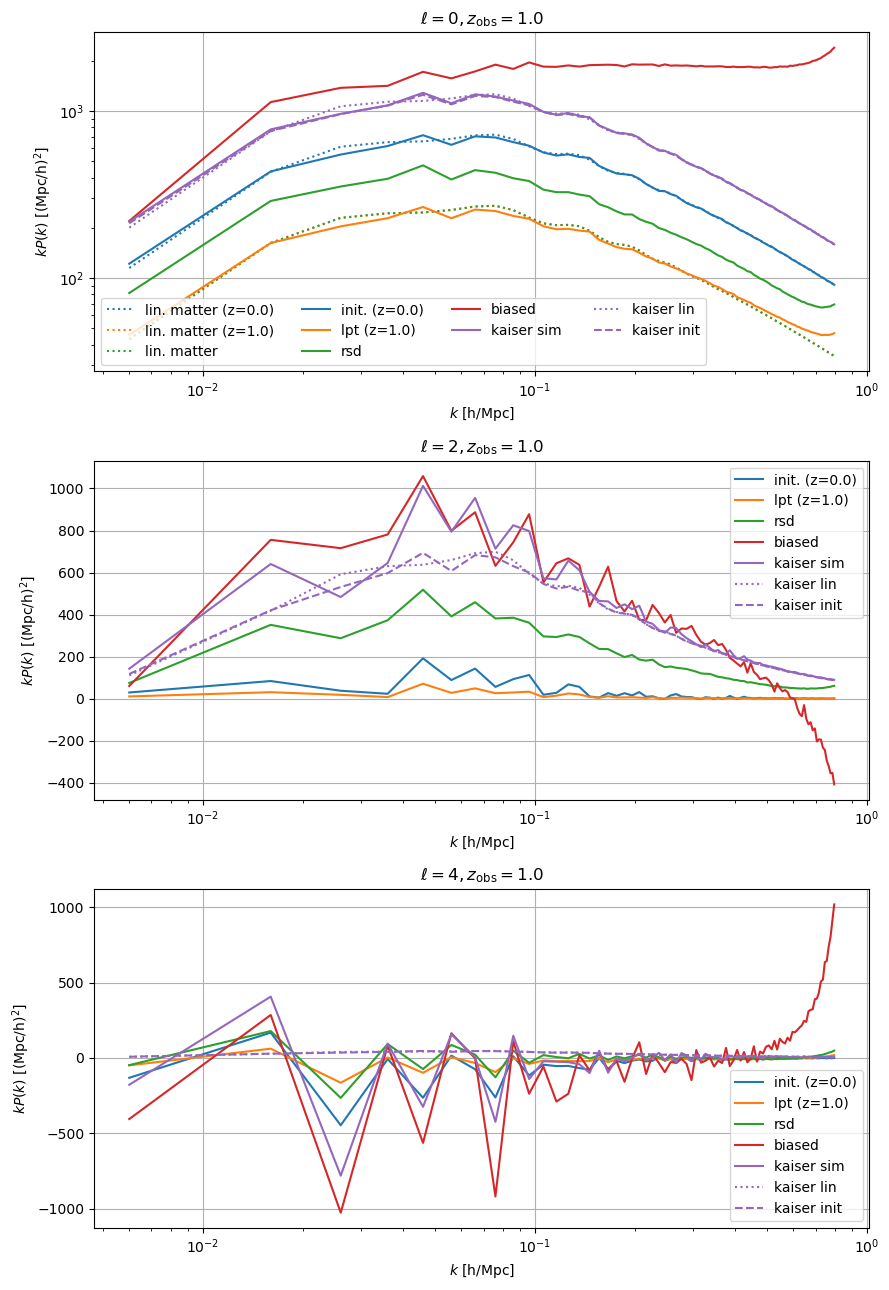

In [52]:
plt.figure(figsize=(9,13))
for i_pole, multipole in enumerate(multipoles):
    plt.subplot(len(multipoles), 1, i_pole+1)

    if multipole==0:
        plot_fn = lambda pk, *args, **kwargs: plt.loglog(pk[0], pk[0]*pk[1][i_pole], *args, **kwargs)
        plot_fn([pk_init[0], [pk_lin_init(pk_init[0])]], 'C0:', label=f"lin. matter (z={1/1-1:.1f})")
        plot_fn([pk_init[0], [pk_lin_lpt(pk_init[0])]], 'C1:', label=f"lin. matter (z={1/model_kwargs['scale_factor_lpt']-1:.1f})")
        plot_fn([pk_init[0], [pk_lin_obs(pk_init[0])]], 'C2:', label=f"lin. matter")
    else:
        plot_fn = lambda pk, *args, **kwargs: plt.semilogx(pk[0], pk[0]*pk[1][i_pole], *args, **kwargs)

    plot_fn(pk_init, 'C0', label=f"init. (z={1/1-1:.1f})")
    plot_fn(pk_lpt, 'C1', label=f"lpt (z={1/model_kwargs['scale_factor_lpt']-1:.1f})")
    plot_fn(pk_rsd, 'C2', label=f"rsd")
    plot_fn(pk_biased, 'C3', label=f"biased")

    plot_fn(pk_kaiser_bias, 'C4', label=f"kaiser sim ")
    plot_fn(pk_kaiser_lin, 'C4:', label=f"kaiser lin")
    plot_fn(pk_kaiser_init, 'C4--', label=f"kaiser init")

    if multipole==0: plt.legend(ncols=4)
    else: plt.legend()
    plt.grid(), plt.xlabel("$k$ [h/Mpc]"), plt.ylabel("$k P(k)$ [(Mpc/h)$^2$]")
    plt.title(r"$\ell="+f"{multipole}, "+r"z_{\text{obs}}="+f"{1/model_kwargs['scale_factor_obs']-1:.1f}$")
plt.tight_layout()
plt.savefig("../scratch/npys/kPk_256_1000Mpcph")
plt.show();

## Bias effects

In [47]:
# Cosmological parameters
cosmo_var_names = ['Omega_c', 'sigma8']
cosmo_var_labels = [r'\Omega_c', r'\sigma_8']
# TODO: dict name:(mean, var) or (min,max) for cosmo_prior?

cond_params = {var_name+"_base": 0. for var_name in cosmo_var_names}
multipoles = [0, 2, 4]
dk = 0.01

pk_biases = []
bias_vals = [-3, 3]
bias_names = ['b2','bnl', 'bs']
bias_name_vals = [['b2', 0]]
for bias_name in bias_names:
    for bias_val in bias_vals:
        bias_name_vals.append([bias_name, bias_val])

for bias_name, bias_val in bias_name_vals:
    cond_params['b1'] = 1
    cond_params['b2'] = 0
    cond_params['bnl'] = 0
    cond_params['bs'] = 0
    cond_params[bias_name] = bias_val

    fiducial_model = condition(forward_model, cond_params) # NOTE: Only condition on random sites, not deterministic ones
    fiducial_trace = trace(seed(fiducial_model, rng_seed=0)).get_trace(**model_kwargs)
    biased_mesh = fiducial_trace['biased_mesh']['value']
    pk_biases.append(power_spectrum(compensate_cic(biased_mesh), kmin=0.001, dk=dk, box_size=model_kwargs['box_size'], multipoles=multipoles))

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


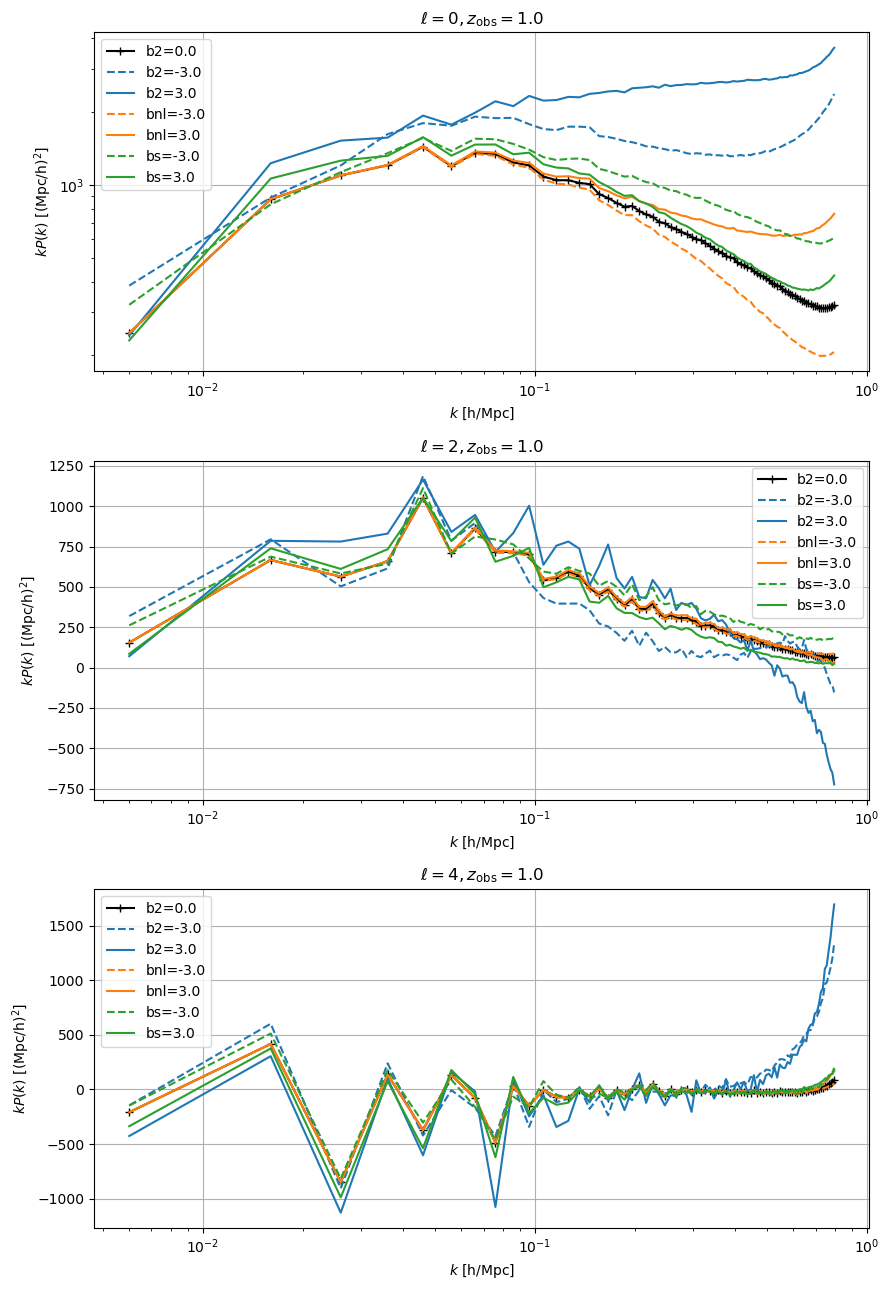

In [53]:
plt.figure(figsize=(9,13))
for i_pole, multipole in enumerate(multipoles):
    plt.subplot(len(multipoles), 1, i_pole+1)

    if multipole==0:
        plot_fn = lambda pk, *args, **kwargs: plt.loglog(pk[0], pk[0]*pk[1][i_pole], *args, **kwargs)
    else:
        plot_fn = lambda pk, *args, **kwargs: plt.semilogx(pk[0], pk[0]*pk[1][i_pole], *args, **kwargs)

    colors = ['k+-','C0','C1','C2']
    i_color = 0
    format = colors[i_color]
    for pk, (bias_name, bias_val) in zip(pk_biases, bias_name_vals):
        if bias_val<0:
            i_color+=1
            format = colors[i_color]+'--'
        elif bias_val>0:
            format = colors[i_color]
        plot_fn(pk, format, label=f"{bias_name}={bias_val:.1f}")

    plt.legend(), plt.grid(), plt.xlabel("$k$ [h/Mpc]"), plt.ylabel("$k P(k)$ [(Mpc/h)$^2$]")
    plt.title(r"$\ell="+f"{multipole}, "+r"z_{\text{obs}}="+f"{1/model_kwargs['scale_factor_obs']-1:.1f}$")
plt.tight_layout()
plt.savefig("../scratch/npys/kPk_256_1000Mpcph_biases")
plt.show();

## Cubes

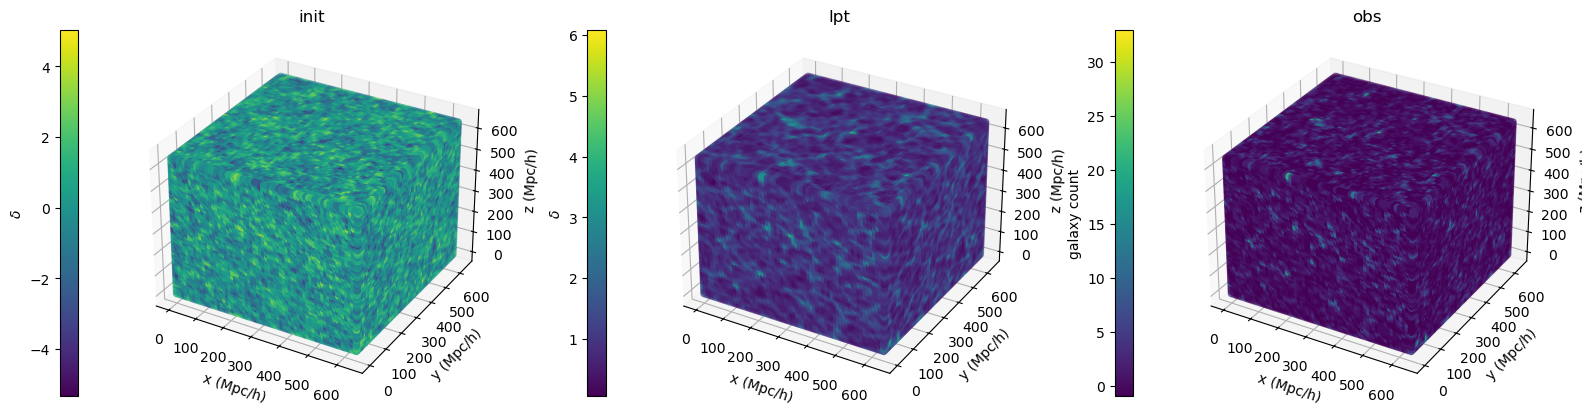

In [ ]:
plt.figure(figsize=(16,4))
# # xx, yy, zz = np.indices(cmb_mesh.shape) # to get indices
xx, yy, zz = np.mgrid[[slice(0,box_length,init_mesh.shape[i]*1j) 
                       for i, box_length in enumerate(model_kwargs['box_size'])]] # to get distances
cmap = plt.colormaps['viridis']

ax3D = plt.subplot(131, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=init_mesh, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta$")
plt.title("init")

ax3D = plt.subplot(132, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=lpt_mesh, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta$")
plt.title("lpt")

ax3D = plt.subplot(133, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=obs_mesh, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"galaxy count")
plt.title("obs")
# ax3D.set_box_aspect(None, zoom=0.8)

plt.tight_layout(), plt.show();

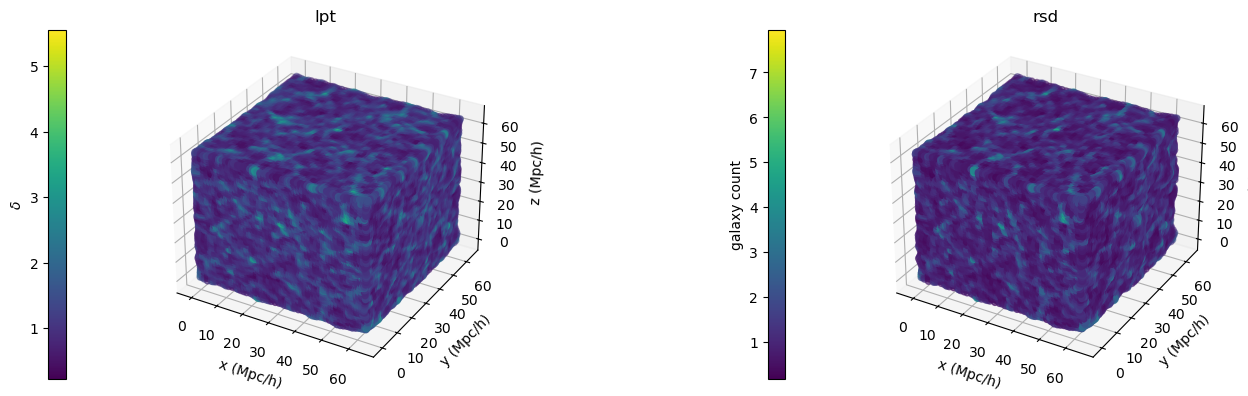

In [8]:
%matplotlib inline
plt.figure(figsize=(16,4))
cmap = plt.colormaps['viridis']

ax3D = plt.subplot(121, projection='3d')
pos = fiducial_trace['lpt_part']['value']
p3d = ax3D.scatter(pos[:,0], pos[:,1], pos[:,2], marker ="o", c=cic_read(lpt_mesh, pos))
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta$")
plt.title("lpt")

ax3D = plt.subplot(122, projection='3d')
pos = fiducial_trace['rsd_part']['value']
p3d = ax3D.scatter(pos[:,0], pos[:,1], pos[:,2], marker ="o", c=cic_read(rsd_mesh, pos))
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"galaxy count")
plt.title("rsd")

plt.tight_layout(), plt.show();